In [1]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [102]:
from matplotlib import rcParams
default_font = 12
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange', 'grey'] #rew #nrew #rew_test #nrew_test #GI

In [103]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
all_sessions = VG11 + VG14 + VG15
all_sessions

[{'mname': 'VG11', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_14', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_21', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_31', 'blk': '2'}]

<AxesSubplot:>

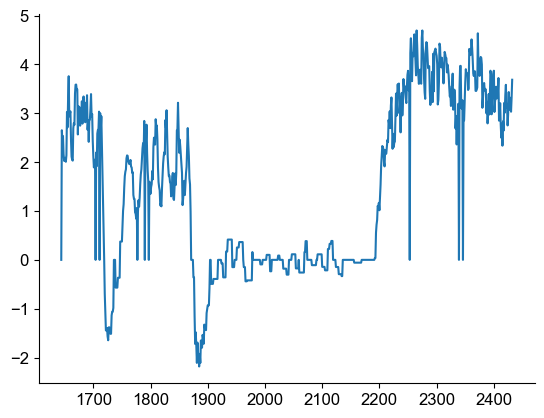

In [139]:
df = utils.get_movement_df(m1)


In [177]:

#create a new variable on df with a 5 window avg of pitch 
df['pitch_avg'] = df['pitch'].rolling(5).mean() * 10
# fill nans with the first rolling avg val 
df['pitch_avg'] = df['pitch_avg'].fillna(df['pitch_avg'][4])
df.head()

,pitch,roll,yaw,distance,trial,time,alpha,distance_interp,vel_interp,dd,dt,speed,pitch_avg
0,0.0000,0.0000,0.0,0.00,1.0,0.000000,0.000000,0.00,0.000000,0.00,0.114000,0.000000,26.8678
1,3.0781,3.0781,12626326.0,0.00,1.0,0.114000,0.000000,0.00,4.353091,0.95,0.028003,33.924937,26.8678
2,3.5463,3.5463,12626383.0,0.95,1.0,0.142003,0.006333,0.95,9.368316,0.95,0.014001,67.852296,26.8678
3,3.3805,3.3805,12626391.0,1.90,1.0,0.156004,0.012667,1.90,14.149065,0.95,0.014001,67.852296,26.8678
4,3.4290,3.4290,12626398.0,2.85,1.0,0.170005,0.019000,2.85,18.998404,0.95,0.026996,35.190399,26.8678


In [183]:
df.query("trial == 4")

,pitch,roll,yaw,distance,trial,time,alpha,distance_interp,vel_interp,dd,dt,speed,pitch_avg
2433,0.0000,0.0000,0.0,0.00,4.0,28.867998,0.000000,1200.00,0.000000,0.00,0.019001,0.000000,26.7098
2434,3.0757,3.0757,12634162.0,0.00,4.0,28.886999,0.000000,1200.00,4.349697,0.95,0.034007,27.935425,26.2254
2435,0.0000,0.0000,12634168.0,0.95,4.0,28.921006,0.006333,1200.95,4.349697,0.00,0.007996,0.000000,20.1592
2436,2.3163,2.3163,12634176.0,0.95,4.0,28.929002,0.006333,1200.95,7.625440,0.95,0.009002,105.532104,18.1588
2437,2.1950,2.1950,12634180.0,1.90,4.0,28.938004,0.012667,1201.90,10.729638,0.95,0.014997,63.346003,15.1740
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,3.7204,3.7204,12637088.0,396.15,4.0,38.677008,0.000000,1596.15,2117.737858,0.95,0.010994,86.410770,39.0104
3301,4.6162,4.6162,12637097.0,397.10,4.0,38.688002,0.000000,1597.10,2124.266150,0.95,0.019000,50.000000,39.7880
3302,4.2229,4.2229,12637106.0,398.05,4.0,38.707002,0.000000,1598.05,2130.238233,0.95,0.016998,55.888928,40.2582
3303,4.0163,4.0163,12637114.0,399.00,4.0,38.724000,0.000000,1599.00,2135.918139,0.95,0.013006,73.043211,40.2990


In [182]:
m1.frameselector.query("trial_no == 5")

,trial_no,trial_type,contrast,speed,distance,reward_delivery,intertrial,time_fromstart,time_within_trial,istim
frame,,,,,,,,,,
163,5.0,non rewarded test,0.057885,56.932981,8.682756,NaN,False,38.957916,0.000000,2.0
164,5.0,non rewarded test,0.184467,56.909997,27.670019,NaN,False,39.291418,0.333502,2.0
165,5.0,non rewarded test,0.306063,56.914175,45.909502,NaN,False,39.611915,0.653999,2.0
166,5.0,non rewarded test,0.420254,56.569662,63.038051,NaN,False,39.912869,0.954953,2.0
167,5.0,non rewarded test,0.537106,57.375797,80.565934,NaN,False,40.222715,1.264799,2.0
168,5.0,non rewarded test,0.655201,56.589102,98.280080,NaN,False,40.531454,1.573538,2.0
169,5.0,non rewarded test,0.785313,56.874715,117.796983,NaN,False,40.876342,1.918426,2.0
170,5.0,non rewarded test,0.903345,57.365284,135.501740,NaN,False,41.187636,2.229720,2.0
171,5.0,non rewarded test,0.985472,57.247078,152.179262,NaN,False,41.478361,2.520445,2.0


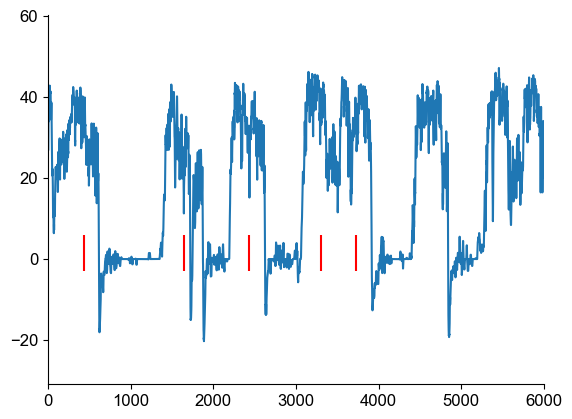

In [180]:
df.pitch_avg.plot(xlim=(0, 6000))
plt.vlines([435,1643,2432, 3304, 3732],-3, 6 , color='r')


In [193]:
def compute_speed(frameselector):
    frameselector = frameselector.assign(speed = 0)
    for trial_no in frameselector["trial_no"].unique():
        trial_inf = frameselector.query(f"trial_no == {trial_no}")
        dt = trial_inf["time_within_trial"].diff().shift(-1)
        ddistance = trial_inf["distance"].diff().shift(-1)
        last_dd = ddistance.iloc[-2]
        last_dt = dt.iloc[-2]
        dt = dt.fillna(last_dt)
        ddistance = ddistance.fillna(last_dd)
        frameselector.loc[frameselector["trial_no"] == trial_no, "speed"] = ddistance / dt
    return frameselector

def get_interp_speed(m1):
    #compute speed
    m1.frameselector = compute_speed(m1.frameselector)
    ntrials = m1.frameselector["trial_no"].astype(int).max()
    speed_interp = np.empty((ntrials, 400))
    #interp speed to 400 positions
    for trial_no in m1.frameselector["trial_no"].unique():
        trial_no = int(trial_no)
        trial_speed = m1.frameselector.query(f"trial_no == {trial_no}")["speed"].values
        trial_distance = m1.frameselector.query(f"trial_no == {trial_no}")["distance"].values
        #if (trial_distance[0] > 0) & (trial_no > 1):
        #    previous_trial_speed = m1.frameselector.query(f"trial_no == {trial_no-1}")["speed"].values[-1]
        #    #append 0 to the beginning
        #    trial_distance = np.insert(trial_distance, 0, 0)
        #    trial_speed = np.insert(trial_speed, 0, previous_trial_speed)
        #elif (trial_distance[0] > 0) & (trial_no == 1):
        #    trial_distance = np.insert(trial_distance, 0, 0)
        #    trial_speed = np.insert(trial_speed, 0, trial_speed[0])
        #trial_distance = np.round(trial_distance, 0).astype(int)
        speed_interp[trial_no-1] = np.interp(np.arange(400), trial_distance, trial_speed)
    return speed_interp

def get_interp_speed_v2(m1):
    #compute speed
    df = utils.get_movement_df(m1)
    ntrials = m1.frameselector["trial_no"].astype(int).max()
    speed_interp = np.empty((ntrials, 400))
    #interp speed to 400 positions
    for trial_no in m1.frameselector["trial_no"].unique():
        trial_no = int(trial_no)
        trial_speed = df.query(f"trial == {trial_no}")["pitch"].values * 10
        trial_distance = df.query(f"trial == {trial_no}")["distance"].values
        speed_interp[trial_no-1] = np.interp(np.arange(400), trial_distance, trial_speed)
    return speed_interp

In [196]:
mean_speed_per_trial_type_andlick = np.empty((len(all_sessions), 4, 2, 400)) # animals, trial types, lick/no lick, 400 positions
from pathlib import Path
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    speed_interp = get_interp_speed_v2(m1)
    main_dir = Path(f"../data/{name}/{date}/{blk}")
    if not main_dir.exists():
        main_dir.mkdir(parents=True)
    np.save(main_dir / "speed_interp.npy", speed_interp)
    for it, (ttype, trials) in enumerate(m1.trial_dict.items()):
        t_licks, t_no_licks = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype=ttype)
        mean_licks = np.mean(speed_interp[t_licks], axis=0)
        mean_no_licks = np.mean(speed_interp[t_no_licks], axis=0)
        mean_speed_per_trial_type_andlick[iss, it, 0] =  mean_licks
        mean_speed_per_trial_type_andlick[iss, it, 1] =  mean_no_licks
np.save("../data/overall/mean_speed_per_trial_type_andlick.npy", mean_speed_per_trial_type_andlick)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

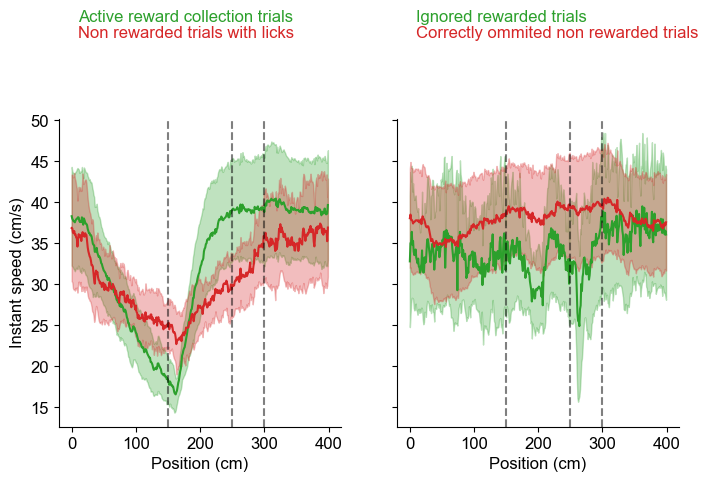

In [197]:
from scipy.stats import sem
cat_a = mean_speed_per_trial_type_andlick[:,[0,2],:].mean(1)
cat_b = mean_speed_per_trial_type_andlick[:,[1,3],:].mean(1)
rew_gran_mean = cat_a.mean(axis=0)
rew_gran_sem = sem(cat_a, axis=0)
nrew_gran_mean = cat_b.mean(axis=0)
nrew_gran_sem = sem(cat_b, axis=0)
fig, ax = plt.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].plot(rew_gran_mean[0], label=ttype, color='tab:green')
ax[0].fill_between(np.arange(400), rew_gran_mean[0]-rew_gran_sem[0], rew_gran_mean[0]+rew_gran_sem[0], alpha=0.3, color='tab:green')
ax[0].plot(nrew_gran_mean[0], label=ttype, color='tab:red')
ax[0].fill_between(np.arange(400), nrew_gran_mean[0]-nrew_gran_sem[0], nrew_gran_mean[0]+nrew_gran_sem[0], alpha=0.3, color='tab:red')
ax[1].plot(rew_gran_mean[1], label=ttype, color='tab:green')
ax[1].fill_between(np.arange(400), rew_gran_mean[1]-rew_gran_sem[1], rew_gran_mean[1]+rew_gran_sem[1], alpha=0.3, color='tab:green')
ax[1].plot(nrew_gran_mean[1], label=ttype, color='tab:red')
ax[1].fill_between(np.arange(400), nrew_gran_mean[1]-nrew_gran_sem[1], nrew_gran_mean[1]+nrew_gran_sem[1], alpha=0.3, color='tab:red')
ax[0].set_ylabel("Instant speed (cm/s)")
ax[0].text(10,62, "Active reward collection trials", color='tab:green')
ax[0].text(10,60, "Non rewarded trials with licks", color='tab:red')
ax[1].text(10,62, "Ignored rewarded trials", color='tab:green')
ax[1].text(10,60, "Correctly ommited non rewarded trials", color='tab:red')
for i in range(2):
    ax[i].set_xlabel("Position (cm)")
    ax[i].axvline(150, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(250, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(300, color='k', linestyle='--', alpha=0.5)

Ttest_relResult(statistic=-0.5738049372938795, pvalue=0.6062949095088941)
Ttest_relResult(statistic=-1.9735356828102115, pvalue=0.14295378129012296)


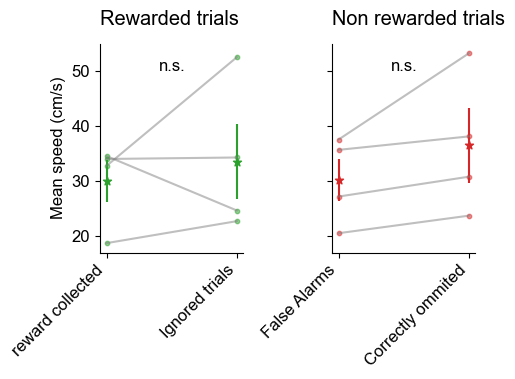

In [200]:
overall_speed_A = cat_a[:,:,0:125].mean(-1)
overall_speed_B = cat_b[:,:,0:125].mean(-1)
overall_speed_A_sem = sem(overall_speed_A, axis=0)
overall_speed_B_sem = sem(overall_speed_B, axis=0)

fig, ax = plt.subplots(1,2, figsize=(5, 4), sharey=True)
for animal in range(4):
    ax[0].scatter(0,overall_speed_A[animal,0], color='tab:green', label="Active reward collection", alpha=0.5, s=10)
    ax[0].scatter(1,overall_speed_A[animal,1],  color='tab:green', label="Ignored rewarded trials", alpha=0.5, s=10)
    ax[1].scatter(0,overall_speed_B[animal,0], color='tab:red', label="Non rewarded trials with licks", alpha=0.5, s=10)
    ax[1].scatter(1,overall_speed_B[animal,1], color='tab:red', label="Correctly ommited non rewarded trials",alpha=0.5, s=10)
ax[0].errorbar(0, overall_speed_A.mean(0)[0], yerr=overall_speed_A_sem[0], color='tab:green')
ax[0].scatter(0, overall_speed_A.mean(0)[0], marker='*', color='tab:green')
ax[0].errorbar(1, overall_speed_A.mean(0)[1], yerr=overall_speed_A_sem[1], color='tab:green')
ax[0].scatter(1, overall_speed_A.mean(0)[1], marker='*', color='tab:green')
ax[1].errorbar(0, overall_speed_B.mean(0)[0], yerr=overall_speed_A_sem[0], color='tab:red')
ax[1].scatter(0, overall_speed_B.mean(0)[0], marker='*', color='tab:red')
ax[1].errorbar(1, overall_speed_B.mean(0)[1], yerr=overall_speed_A_sem[1], color='tab:red')
ax[1].scatter(1, overall_speed_B.mean(0)[1], marker='*', color='tab:red')
ax[0].set_ylabel("Mean speed (cm/s)")
ax[0].set_title("Rewarded trials", y=1.05)
ax[1].set_title("Non rewarded trials", y=1.05)
ax[0].set_xticks([0,1], ["reward collected", "Ignored trials"], rotation=45, ha='right');
ax[1].set_xticks([0,1], ["False Alarms", "Correctly ommited"], rotation=45, ha='right');
# connect dots 
for animal in range(4):
    ax[0].plot([0,1], [overall_speed_A[animal,0], overall_speed_A[animal,1]], color='grey', alpha=0.5)
    ax[1].plot([0,1], [overall_speed_B[animal,0], overall_speed_B[animal,1]], color='grey', alpha=0.5)
ax[0].text(0.4, 50, "n.s.")
ax[1].text(0.4, 50, "n.s.")
plt.tight_layout()
# compute the paired ttest between the two conditions
from scipy.stats import ttest_rel
print(ttest_rel(overall_speed_A[:,0], overall_speed_A[:,1]))
print(ttest_rel(overall_speed_B[:,0], overall_speed_B[:,1]))



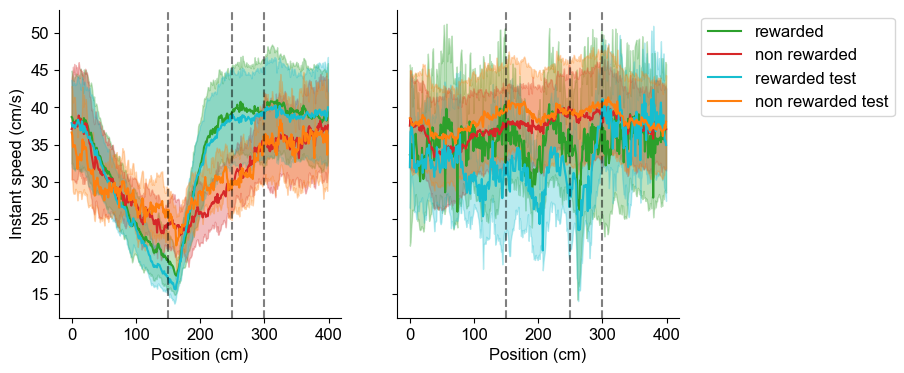

In [199]:
from scipy.stats import sem
grand_mean = np.mean(mean_speed_per_trial_type_andlick, axis=0)
gsem = sem(mean_speed_per_trial_type_andlick, axis=0)
fig, ax = plt.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
for it, ttype in enumerate(m1.trial_dict.keys()):
    ax[0].plot(grand_mean[it, 0], label=ttype, color=trial_type_palette[it])
    ax[0].fill_between(np.arange(400), grand_mean[it, 0]-gsem[it, 0], grand_mean[it, 0]+gsem[it, 0], alpha=0.3, color=trial_type_palette[it])
    ax[1].plot(grand_mean[it, 1], label=ttype, color=trial_type_palette[it])
    ax[1].fill_between(np.arange(400), grand_mean[it, 1]-gsem[it, 1], grand_mean[it, 1]+gsem[it, 1], alpha=0.3, color=trial_type_palette[it])
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_ylabel("Instant speed (cm/s)")
for i in range(2):
    ax[i].set_xlabel("Position (cm)")
    ax[i].axvline(150, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(250, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(300, color='k', linestyle='--', alpha=0.5)

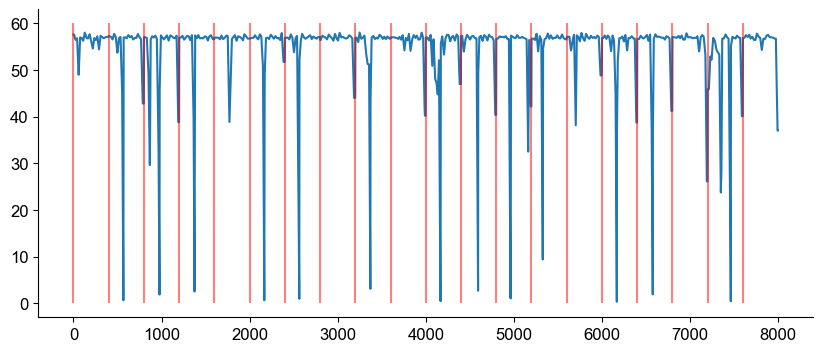

In [136]:
plt.figure(figsize=(10, 4))
plt.plot(speed_interp.flatten()[:400*20])
plt.vlines(np.arange(0,400*20,400), 0, 60, color='r', alpha=0.5)

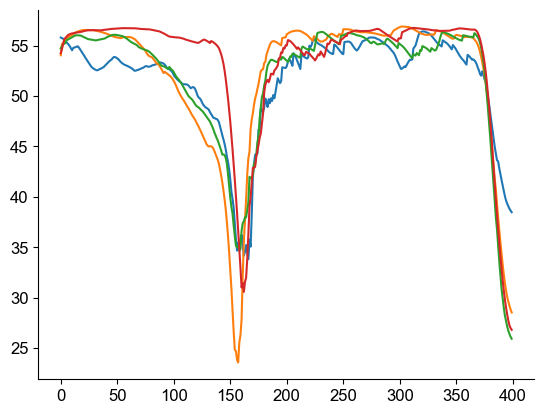

In [134]:
for i in range(4):
    plt.plot(np.arange(400),mean_speed_per_trial_type_andlick[i,0,0])